In [1]:
from collections import Counter

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import string
import nltk
import spacy
from gensim import corpora
from gensim.models import LdaModel, Phrases, TfidfModel
from gensim.models.phrases import Phraser
from nltk import SnowballStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from tqdm import tqdm

from wordcloud import WordCloud

import matplotlib.colors as mcolors

import pyLDAvis.gensim
pyLDAvis.enable_notebook()

nltk.download('punkt')
# !python3 -m spacy download en

[nltk_data] Downloading package punkt to /Users/marcus/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [2]:
grey = (187/255, 187/255, 187/255)
darkgreen = (51/255, 117/255, 56/255)
teal = (93/255, 168/255, 153/255)
blue = (148/255, 203/255, 236/255)
yellow = (220/255, 205/255, 125/255)

color_pallete = sns.color_palette([grey, darkgreen, teal, blue, yellow])

# Feedback Analysis

In [3]:
feedback_df = pd.read_csv('../Menagerie/data/grades.csv', index_col=0)
feedback_df = feedback_df[~feedback_df['grade'].isnull()]
feedback_df

,assignment_number,comments,skill,participant_id,batch,grade
0,18.0,The code use meaningful identifier names and a...,Readability,15,1,B+
1,620.0,Code is well organized into logical classes an...,Readability,15,1,A+
2,466.0,"The code is well-organized, consistently inden...",Readability,15,1,A-
3,591.0,The code is well organized and readable. Inden...,Readability,15,1,A-
4,587.0,The code is well organized and readable. Inden...,Readability,15,1,A-
...,...,...,...,...,...,...
15,58.0,NaN,Documentation,14,1,A++
16,353.0,NaN,Documentation,14,1,A++
17,422.0,NaN,Documentation,14,1,A++
18,480.0,NaN,Documentation,14,1,A++


## Summary Analysis
### Count of submissions with no feedback

In [4]:
count_df = feedback_df.groupby('skill').count().reset_index()
count_df['missing'] = count_df['assignment_number'] - count_df['comments']
count_df

,skill,assignment_number,comments,participant_id,batch,grade,missing
0,Code Elegance,1120,677,1120,1120,1120,443
1,Correctness,1116,714,1116,1116,1116,402
2,Documentation,1118,710,1118,1118,1118,408
3,Readability,1120,631,1120,1120,1120,489


<Axes: xlabel='skill', ylabel='missing'>

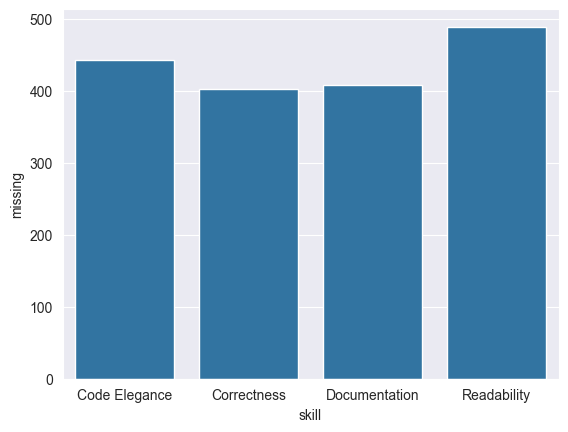

In [5]:
# Maybe add a plot of count of missing at each grade?
sns.barplot(count_df, x='skill', y='missing')

### NLP Techniques

In [6]:
nlp_df = feedback_df[~feedback_df['comments'].isna()].copy()
nlp_df

,assignment_number,comments,skill,participant_id,batch,grade
0,18.0,The code use meaningful identifier names and a...,Readability,15,1,B+
1,620.0,Code is well organized into logical classes an...,Readability,15,1,A+
2,466.0,"The code is well-organized, consistently inden...",Readability,15,1,A-
3,591.0,The code is well organized and readable. Inden...,Readability,15,1,A-
4,587.0,The code is well organized and readable. Inden...,Readability,15,1,A-
...,...,...,...,...,...,...
11,525.0,the implementation is good but not distinguish...,Correctness,14,1,A
19,334.0,Not compiling to be specific MusicPlayer.java,Correctness,14,1,D-
4,587.0,some comments are redundant or state the obvio...,Code Elegance,14,1,A-
7,47.0,"Some methods lack detailed comments, making it...",Documentation,14,1,A++


In [7]:
base_stopwords = nltk.corpus.stopwords.words('english')
base_stopwords += ['readability', 'correctness', 'documentation', 'maintainability', 'student', 'application', 'base', 'addition', 'animal', 'effect', 'approach', 'assignment', 'simulation', 'weather', 'species', 'disease', 'plant', 'code', 'baseline', 'time', 'day', 'predator', 'requirement', 'track', 'level', 'resource', 'fight', 'feature','behavior', 'behaviour', 'standard', 'rabbit', 'gender', 'fox', 'night', 'prey', 'growth', 'meet', 'male', 'female', 'propagate', 'aptitude', 'implementation']

### Sentiment

In [8]:
sia = SentimentIntensityAnalyzer()

def is_positive(comment):
    return sia.polarity_scores(comment)['compound'] > 0

nlp_df['sentiment'] = nlp_df['comments'].apply(is_positive)
nlp_df

,assignment_number,comments,skill,participant_id,batch,grade,sentiment
0,18.0,The code use meaningful identifier names and a...,Readability,15,1,B+,True
1,620.0,Code is well organized into logical classes an...,Readability,15,1,A+,True
2,466.0,"The code is well-organized, consistently inden...",Readability,15,1,A-,True
3,591.0,The code is well organized and readable. Inden...,Readability,15,1,A-,True
4,587.0,The code is well organized and readable. Inden...,Readability,15,1,A-,True
...,...,...,...,...,...,...,...
11,525.0,the implementation is good but not distinguish...,Correctness,14,1,A,False
19,334.0,Not compiling to be specific MusicPlayer.java,Correctness,14,1,D-,False
4,587.0,some comments are redundant or state the obvio...,Code Elegance,14,1,A-,True
7,47.0,"Some methods lack detailed comments, making it...",Documentation,14,1,A++,True


In [9]:
sentiment_df = nlp_df[['skill', 'sentiment', 'assignment_number']].groupby(['skill', 'sentiment']).count().reset_index()
sentiment_df.columns = ['skill', 'sentiment', 'count']
sentiment_df['sentiment'] = sentiment_df['sentiment'].apply(lambda x: 'Positive' if x else 'Negative')
sentiment_df

,skill,sentiment,count
0,Code Elegance,Negative,221
1,Code Elegance,Positive,456
2,Correctness,Negative,261
3,Correctness,Positive,453
4,Documentation,Negative,250
5,Documentation,Positive,460
6,Readability,Negative,152
7,Readability,Positive,479


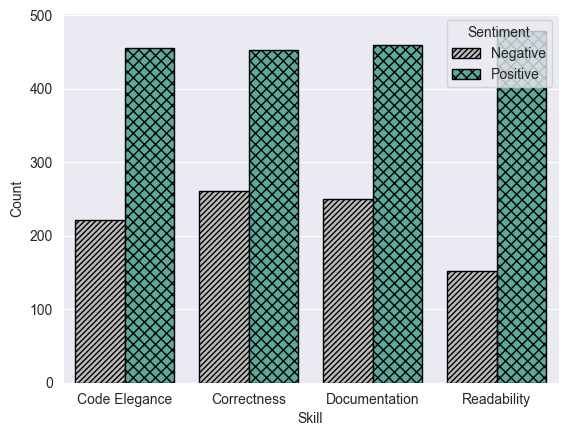

In [10]:
g = sns.barplot(sentiment_df, x='skill', y='count', hue='sentiment')


hatches = ['//', 'x',]
colors = [grey, teal]
styles = zip(hatches, colors)


for style, these_bars in zip(styles, g.containers):
    for this_bar in these_bars:
        this_bar.set_hatch(3 * style[0])
        this_bar.set_facecolor(style[1])
        this_bar.set_edgecolor('black')

g.set(xlabel='Skill', ylabel='Count')
handles = g.get_legend_handles_labels()[0]

for i in range(len(handles)):
    handles[i].set_facecolor(colors[i])
    handles[i].set_hatch(3 * hatches[i])
    handles[i].set_edgecolor('black')

g.legend(title='Sentiment')
g.get_figure().savefig('../plots/sentiment.pdf', bbox_inches='tight')

### LDA Topic Analysis
https://link.springer.com/article/10.1007/s44217-023-00051-0
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9260886/

Code adapted from: https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/#4.-Build-the-Bigram,-Trigram-Models-and-Lemmatize

In [11]:
# TODO: Add plots for dominant topic per document

In [12]:
def process_words(texts, bigram_mod, trigram_mod, stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'], stem=False):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        
    if stem:
        stemmer = SnowballStemmer('english')
        texts_out = [[stemmer.stem(word) for word in doc] for doc in texts_out]
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]

    return texts_out

In [13]:
def get_data(skill, addition_stopwords):
    
    stopwords = base_stopwords + addition_stopwords
    
    text_data = nlp_df[nlp_df['skill'] == skill]['comments']
    bigram = Phrases(text_data, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = Phrases(bigram[text_data], threshold=100)
    bigram_mod = Phraser(bigram)
    trigram_mod = Phraser(trigram)

    processed_text = process_words(text_data, bigram_mod, trigram_mod, stopwords, stem=False, allowed_postags=['NOUN', 'ADVERB'])
    dictionary = corpora.Dictionary(processed_text)
    dictionary.filter_extremes(no_below=15, no_above=0.3, keep_n=10000)
    corpus = [dictionary.doc2bow(text) for text in processed_text]

    model = TfidfModel(corpus)
    tfidf_corpus = [model[i] for i in corpus]
    
    return tfidf_corpus, dictionary, processed_text
    

In [14]:
def generate_topic_model(corpus, dictionary, processed_text, num_topics=5):
    lda_model = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, random_state=100, update_every=1, chunksize=10, passes=15)
    cm = CoherenceModel(model=lda_model, texts=processed_text, coherence='u_mass')
    coherence = cm.get_coherence()
    return lda_model, coherence


In [15]:
def generate_topic_models(tfidf_corpus, dictionary, processed_text):
    models = {}
    coherence_results = []
    
    for topic_count in tqdm(range(2, 10)):
        model, coherence = generate_topic_model(tfidf_corpus, dictionary, processed_text, topic_count)
        models[topic_count] = model
        coherence_results.append({'topic_count':topic_count, 'coherence': coherence})
        
    return models, pd.DataFrame(coherence_results)
    

In [16]:
def run_lda(skill, addition_stopwords=None):
    if addition_stopwords is None:
        addition_stopwords = []
    
    tfidf_corpus, dictionary, processed_text = get_data(skill, addition_stopwords)
    models, coherence_df= generate_topic_models(tfidf_corpus, dictionary, processed_text)
    print(coherence_df[coherence_df['coherence'] == coherence_df['coherence'].max()])

    g = sns.lineplot(coherence_df, x='topic_count', y='coherence')
    g.set(title=skill)
    return models, tfidf_corpus, processed_text

#### Plots

In [17]:
def run_pyLDAvis(models, topic_count):
    return pyLDAvis.gensim.prepare(models[topic_count], corpus, dictionary=models[topic_count].id2word)

In [18]:
def generate_word_cloud(skill, models, topic_count, topic_names=None, additional_stopwords=None):
    if additional_stopwords is None:
        additional_stopwords = {}
        
    stopwords = base_stopwords + additional_stopwords
        
    if topic_names is not None:
        if len(topic_names) < topic_count:
            print('Not enough topic names to generate word cloud')
            return None
        elif len(topic_names) > topic_count:
            print('Too many topic names to generate word cloud')
            return None
        
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

    cloud = WordCloud(stopwords=stopwords,
                      background_color='white',
                      width=2500,
                      height=1800,
                      max_words=15,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)
    
    topics = models[topic_count].show_topics(formatted=False, num_words=5)
    
    row_count = topic_count // 2 + topic_count % 2
    fig, axes = plt.subplots(row_count, 2, figsize=(10,10), sharex=True, sharey=True)
    
    for i, ax in enumerate(axes.flatten()):
        if i >= topic_count:
            break
            
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        if topic_names is None:
            plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        else:
            plt.gca().set_title('Topic: ' + topic_names[i], fontdict=dict(size=16))
        plt.gca().axis('off')

    if topic_count % 2 == 1:
        fig.delaxes(axes[row_count - 1, 1])
    
    fig.suptitle(skill, fontsize=22, y=1.05)
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.axis('off')
    plt.margins(x=0, y=0)
    plt.tight_layout()
    plt.show()

In [19]:
# Look for words in multiple topics and have higher frequency then weight. Add these to stop words
def generate_word_count(skill, models, topic_count, data, topic_names=None):
    if topic_names is not None:
        if len(topic_names) < topic_count:
            print('Not enough topic names to generate word cloud')
            return None
        elif len(topic_names) > topic_count:
            print('Too many topic names to generate word cloud')
            return None


    topics = models[topic_count].show_topics(formatted=False)
    data_flat = [w for w_list in data for w in w_list]
    counter = Counter(data_flat)
    
    out = []
    for i, topic in topics:
        for word, weight in topic:
            out.append([word, i , weight, counter[word]])
    
    df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])
    
    # Plot Word Count and Weights of Topic Keywords
    row_count = topic_count // 2 + topic_count % 2
    fig, axes = plt.subplots(row_count, 2, figsize=(16,10), sharey=True, dpi=160)
  
    
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
    for i, ax in enumerate(axes.flatten()):
        if i >= topic_count:
            break
        ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
        ax.set_ylabel('Word Count', color=cols[i])
        # ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
        if topic_names is None:
            ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
        else:
            ax.set_title('Topic: ' + topic_names[i], color=cols[i], fontsize=16)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
        ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

    if topic_count % 2 == 1:
        fig.delaxes(axes[row_count - 1, 1])
    
    fig.tight_layout(w_pad=2)
    fig.suptitle(skill + ' - Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)
    plt.show()
    

### Generate DataFrame of Dominant Topic

In [71]:
def generate_dominant_topics_df(model, corpus, data):
    sent_topics_df = pd.DataFrame(columns=['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords', 'All_Topics'])
    
    for i, row_list in enumerate(model[corpus]):
        row = row_list[0] if model.per_word_topics else row_list
        
        row = sorted(row, key=lambda x : (x[1]), reverse=True)
        
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:
                word_prob = model.show_topic(topic_num)
                topic_keywords = ', '.join([word for word, prop in word_prob])
                temp_df = pd.DataFrame([{'Dominant_Topic': topic_num, 'Perc_Contribution': prop_topic, 'Topic_Keywords': topic_keywords, 'All_Topics': row}])
                sent_topics_df = pd.concat([sent_topics_df, temp_df], ignore_index=True)
            else:
                break
    
    contents = pd.Series(data, name='Original_Data')
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df
            

### Correctness

100%|██████████| 8/8 [00:02<00:00,  3.30it/s]

   topic_count  coherence
1            3 -12.758392


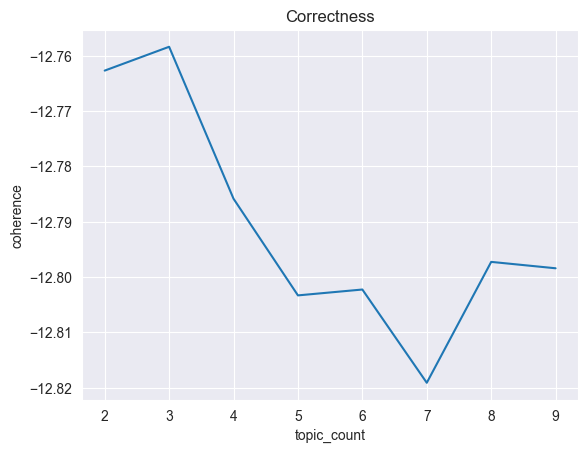

In [21]:
additional_stopwords = ['implementation', 'source', 'issue', 'class']
models, corpus, processed_text= run_lda('Correctness', additional_stopwords)

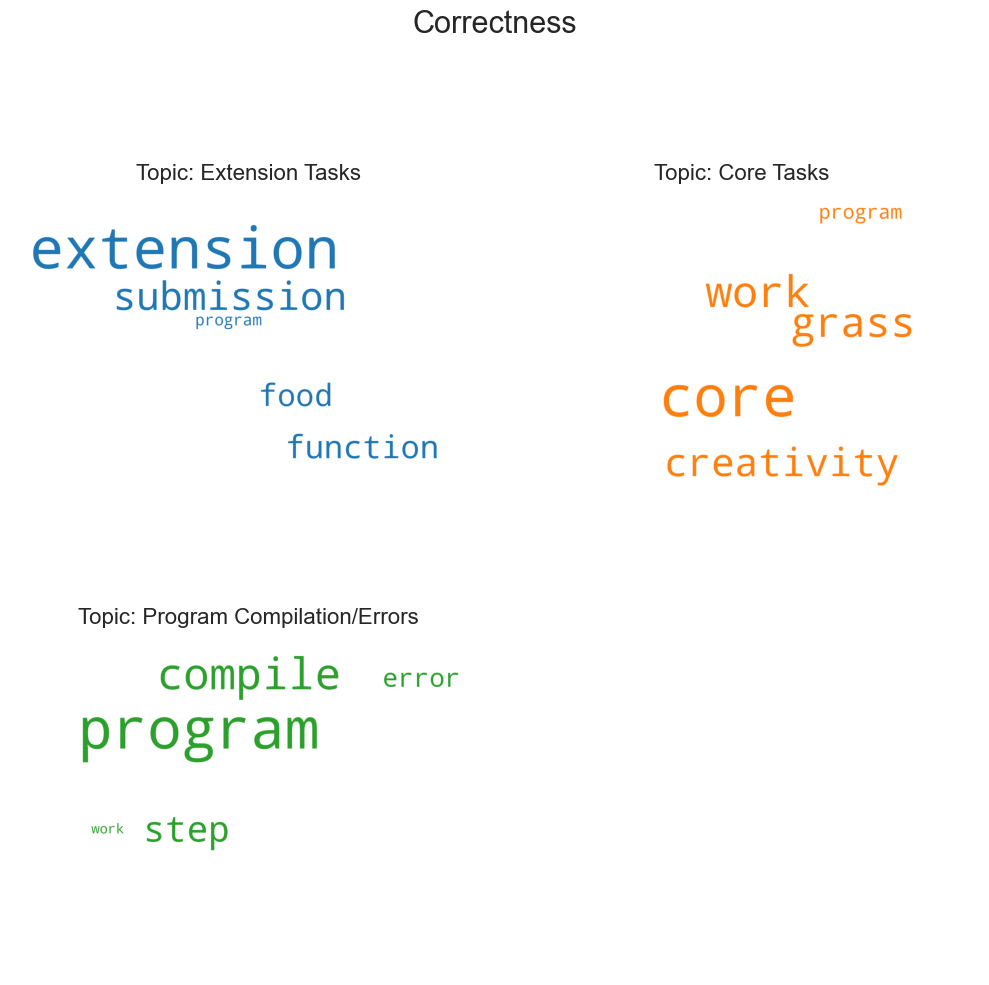

/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_63184/482231609.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_63184/482231609.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_63184/482231609.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


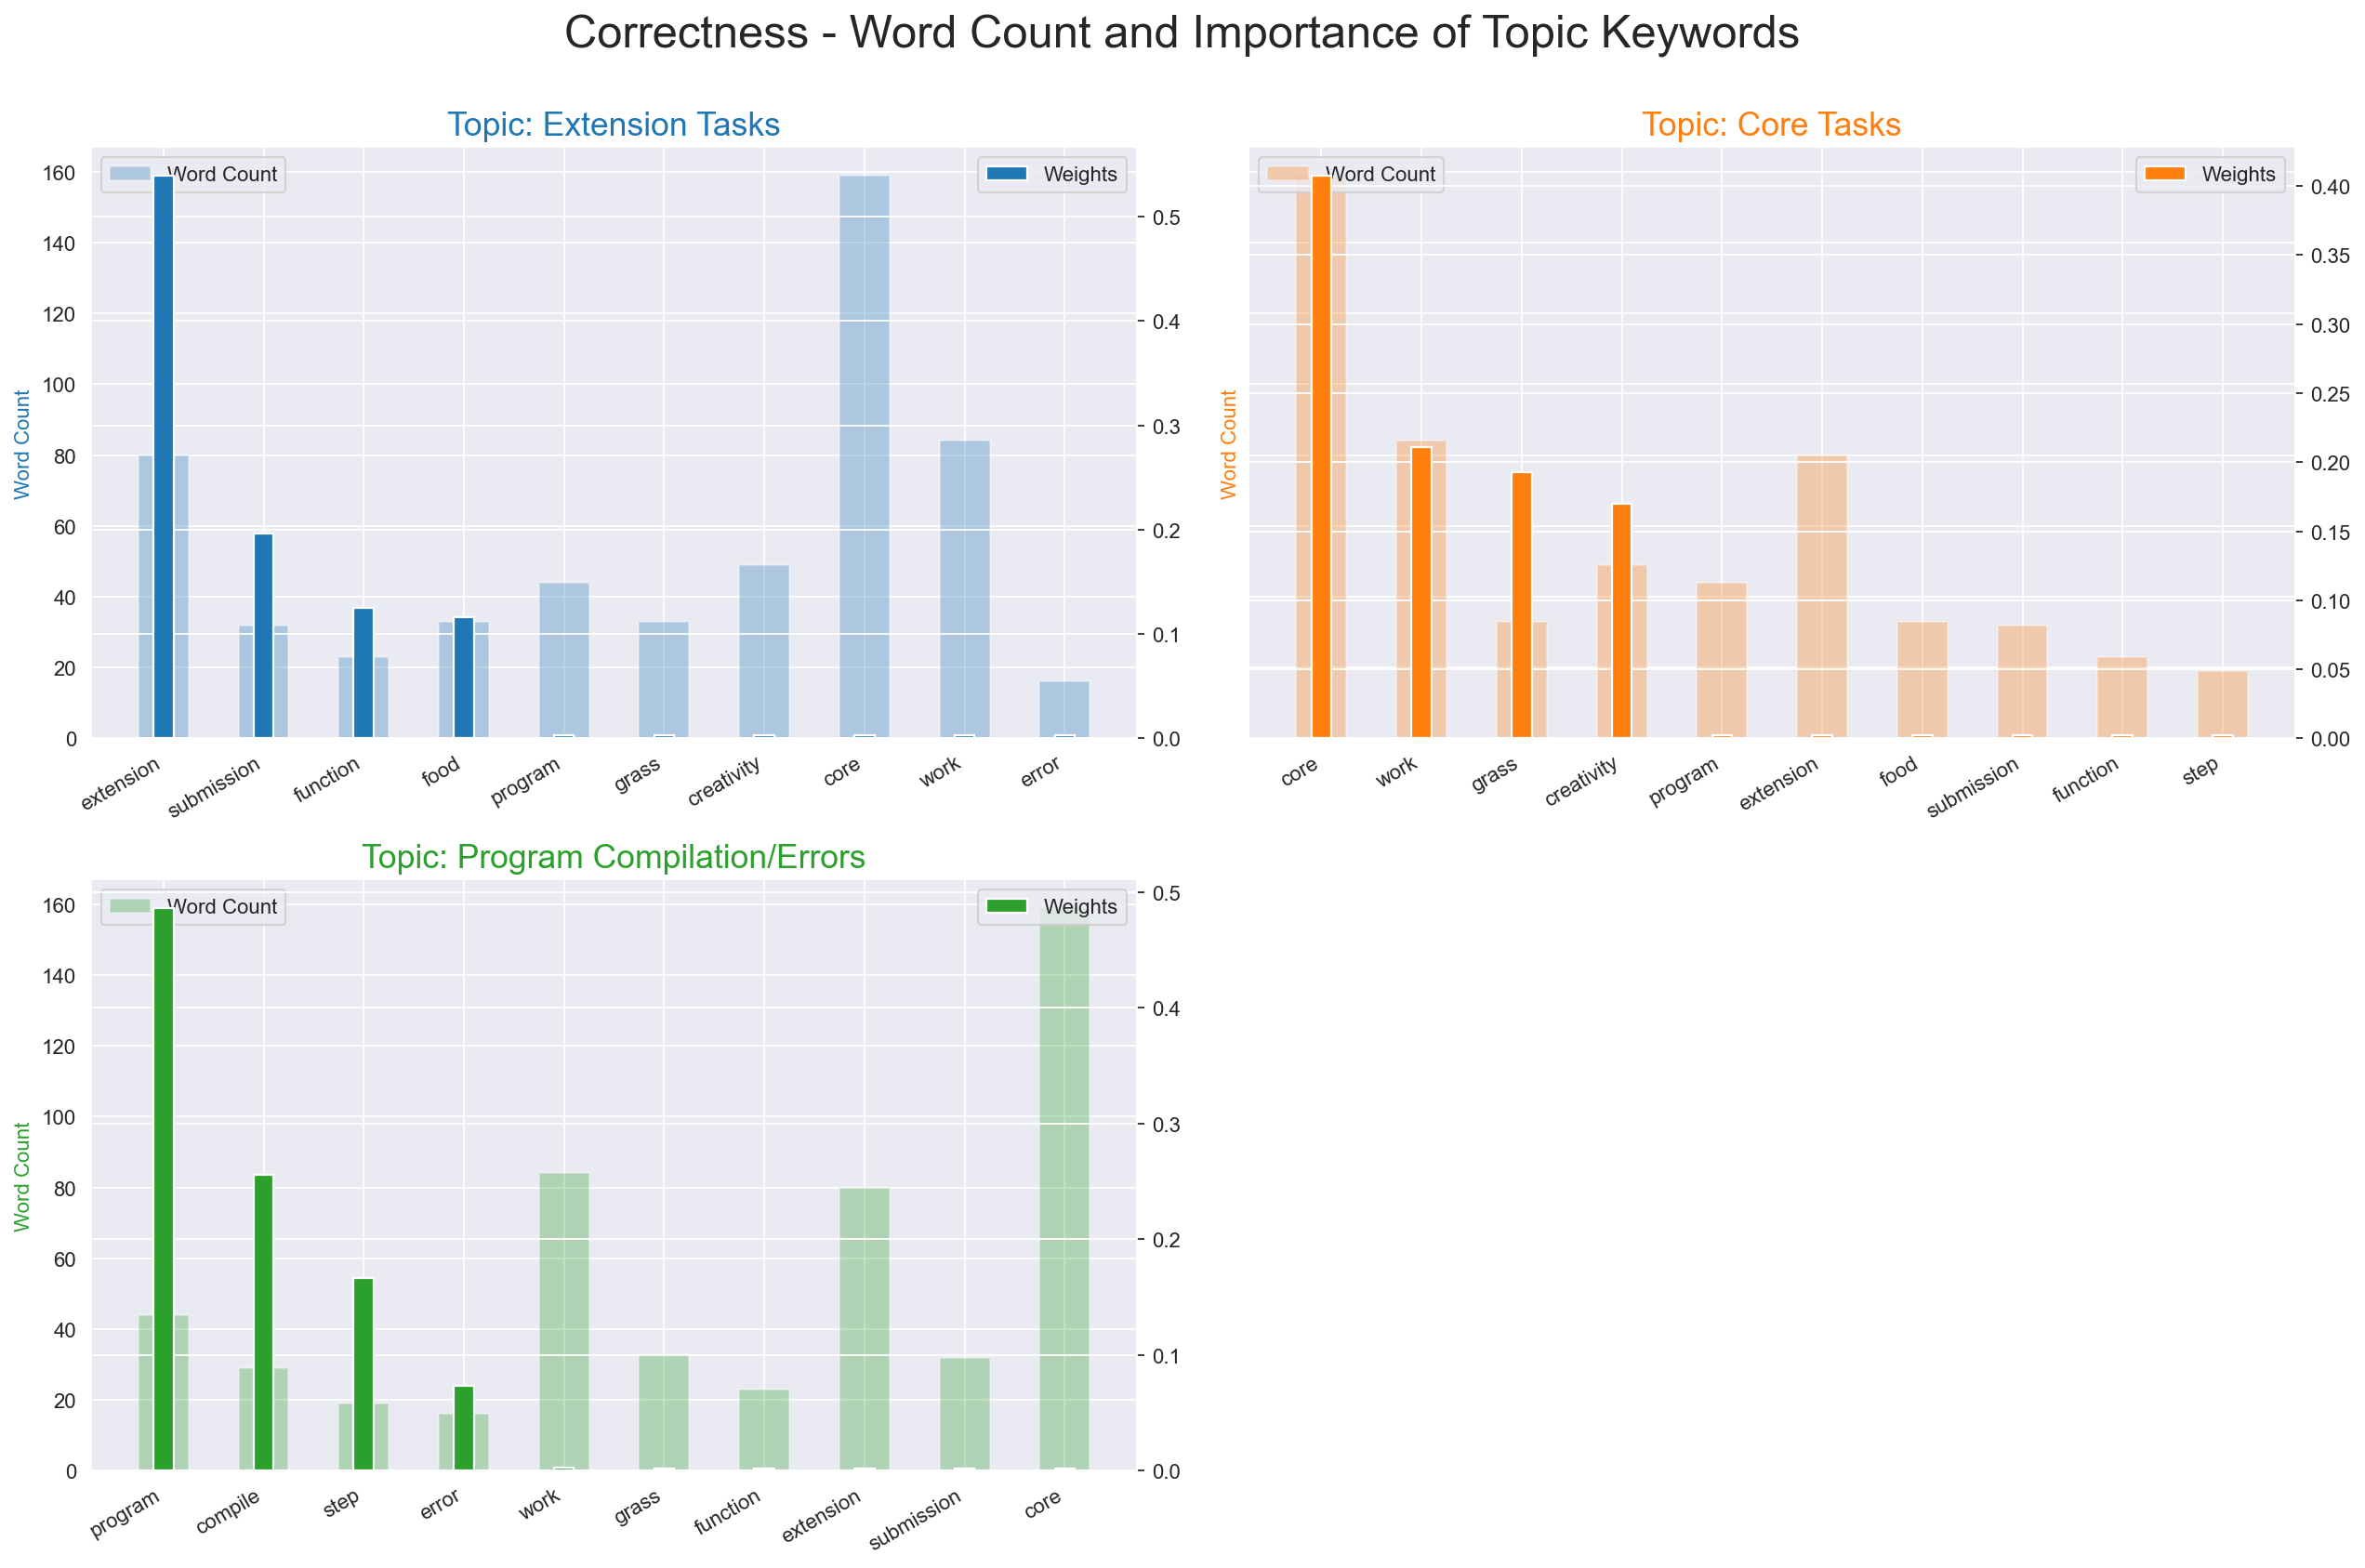

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.262964  0.252479       1        1  40.920988
0      0.089346 -0.351730       2        1  32.326628
2     -0.352310  0.099251       3        1  26.752384, topic_info=          Term       Freq      Total Category  logprob  loglift
4    extension  76.000000  76.000000  Default  12.0000  12.0000
10     program  57.000000  57.000000  Default  11.0000  11.0000
0         core  73.000000  73.000000  Default  10.0000  10.0000
8      compile  30.000000  30.000000  Default   9.0000   9.0000
2         work  38.000000  38.000000  Default   8.0000   8.0000
5   submission  28.000000  28.000000  Default   7.0000   7.0000
3        grass  35.000000  35.000000  Default   6.0000   6.0000
11        step  20.000000  20.000000  Default   5.0000   5.0000
9   creativity  31.000000  31.000000  Default   4.0000   4.0000
6     function  18.000000  18.000000  Default   3.0000   3.0000
1         food  17.000000  17.000000  Default   2.0000   2.0000
7        error   9.000000   9.000000  Default   1.0000   1.0000
0         core  72.759385  73.429233   Topic1  -0.8974   0.8844
2         work  37.620165  38.358371   Topic1  -1.5570   0.8741
3        grass  34.358336  35.045536   Topic1  -1.6477   0.8737
9   creativity  30.343151  31.011962   Topic1  -1.7720   0.8717
7        error   0.417877   9.343326   Topic1  -6.0571  -2.2137
1         food   0.423736  17.027108   Topic1  -6.0432  -2.7999
6     function   0.419564  18.379582   Topic1  -6.0531  -2.8863
11        step   0.419311  20.230149   Topic1  -6.0537  -2.9828
5   submission   0.421560  28.313381   Topic1  -6.0483  -3.3136
8      compile   0.418338  30.639580   Topic1  -6.0560  -3.4002
10     program   0.466755  57.664452   Topic1  -5.9465  -3.9231
4    extension   0.424620  76.746192   Topic1  -6.0411  -4.3035
4    extension  76.060884  76.746192   Topic2  -0.6173   1.1203
5   submission  27.634223  28.313381   Topic2  -1.6297   1.1050
6     function  17.690359  18.379582   Topic2  -2.0758   1.0911
1         food  16.348608  17.027108   Topic2  -2.1547   1.0886
7        error   0.401109   9.343326   Topic2  -5.8623  -2.0189
11        step   0.400274  20.230149   Topic2  -5.8644  -2.7935
9   creativity   0.412496  31.011962   Topic2  -5.8343  -3.1906
8      compile   0.399378  30.639580   Topic2  -5.8666  -3.2109
3        grass   0.416758  35.045536   Topic2  -5.8240  -3.3026
2         work   0.411767  38.358371   Topic2  -5.8361  -3.4050
10     program   0.416901  57.664452   Topic2  -5.8237  -3.8003
0         core   0.412392  73.429233   Topic2  -5.8346  -4.0528
10     program  56.780797  57.664452   Topic3  -0.7203   1.3031
8      compile  29.821864  30.639580   Topic3  -1.3643   1.2915
11        step  19.410564  20.230149   Topic3  -1.7937   1.2772
7        error   8.524341   9.343326   Topic3  -2.6166   1.2268
1         food   0.254764  17.027108   Topic3  -6.1269  -2.8837
6     function   0.269659  18.379582   Topic3  -6.0701  -2.9033
5   submission   0.257598  28.313381   Topic3  -6.1159  -3.3811
2         work   0.326439  38.358371   Topic3  -5.8790  -3.4479
9   creativity   0.256315  31.011962   Topic3  -6.1209  -3.4772
3        grass   0.270443  35.045536   Topic3  -6.0672  -3.5458
0         core   0.257456  73.429233   Topic3  -6.1164  -4.3347
4    extension   0.260689  76.746192   Topic3  -6.1040  -4.3664, token_table=      Topic      Freq        Term
term                             
8         3  0.979126     compile
0         1  0.994154        core
9         1  0.967369  creativity
7         3  0.963254       error
4         2  0.990277   extension
1         2  0.939678        food
6         2  0.979348    function
3         1  0.970166       grass
10        3  0.988477     program
11        3  0.939192        step
5         2  0.988932  submission
2         1  0.990657        work, R=12, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC

In [22]:
TOPIC_COUNT = 3
topic_names = {0: 'Extension Tasks', 1: 'Core Tasks', 2: 'Program Compilation/Errors'}
generate_word_cloud('Correctness', models, TOPIC_COUNT, additional_stopwords=additional_stopwords, topic_names=topic_names)
generate_word_count('Correctness', models, TOPIC_COUNT, processed_text, topic_names=topic_names)
run_pyLDAvis(models, TOPIC_COUNT)

In [72]:
generate_dominant_topics_df(models[TOPIC_COUNT], corpus, processed_text)


/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_63184/463497045.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  sent_topics_df = pd.concat([sent_topics_df, temp_df], ignore_index=True)


,Dominant_Topic,Perc_Contribution,Topic_Keywords,All_Topics,Original_Data
0,1,0.666622,"core, work, grass, creativity, program, extens...","[(1, 0.6666222), (0, 0.1666925), (2, 0.16668531)]","[core, challenge, mission]"
1,1,0.480479,"core, work, grass, creativity, program, extens...","[(1, 0.4804793), (0, 0.39541712), (2, 0.124103...","[work, core, challenge, task, jaguar, gazelle,..."
2,1,0.666622,"core, work, grass, creativity, program, extens...","[(1, 0.6666219), (0, 0.16669269), (2, 0.166685...","[core, challenge, mission]"
3,0,0.508496,"extension, submission, function, food, program...","[(0, 0.50849646), (1, 0.35040906), (2, 0.14109...","[core, wolf, squirrel, chicken, frog, squirrel..."
4,1,0.480479,"core, work, grass, creativity, program, extens...","[(1, 0.48047918), (0, 0.39541724), (2, 0.12410...","[work, core, challenge, task, kind, competitio..."
...,...,...,...,...,...
709,0,0.333333,"extension, submission, function, food, program...","[(0, 0.33333334), (1, 0.33333334), (2, 0.33333...","[challenge, task]"
710,1,0.666563,"core, work, grass, creativity, program, extens...","[(1, 0.6665627), (0, 0.16672382), (2, 0.166713...","[run, grass, grass, simulator, screen]"
711,0,0.333333,"extension, submission, function, food, program...","[(0, 0.33333334), (1, 0.33333334), (2, 0.33333...",[kind]
712,0,0.333333,"extension, submission, function, food, program...","[(0, 0.33333334), (1, 0.33333334), (2, 0.33333...","[color, comprehend]"


### Code Elegance

  0%|          | 0/10 [00:00<?, ?it/s]/Users/marcus/workspace/Programming/Consistency_In_Grading_Analysis/venv3.10/lib/python3.10/site-packages/gensim/models/ldamodel.py:847: RuntimeWarning: divide by zero encountered in scalar divide
  perwordbound = self.bound(chunk, subsample_ratio=subsample_ratio) / (subsample_ratio * corpus_words)
100%|██████████| 10/10 [00:02<00:00,  3.43it/s]

   topic_count  coherence
2            3  -11.09823


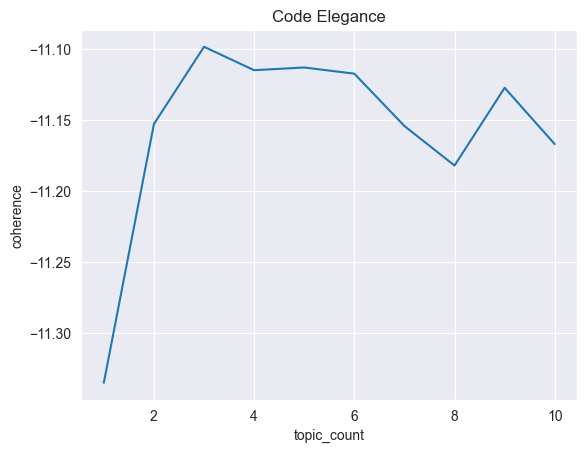

In [289]:
additional_stopwords = ['object', 'principle', 'extensibility', 'use', 'animal', 'logic', 'modularity', 'structure', 'predator', 'prey', 'lot', 'act', 'access', 'block', 'whitespace', 'modifier', 'self', 'challenge', 'core', 'way', 'task', 'findfood', 'type', 'variable', 'example']
models, corpus, processed_text = run_lda('Code Elegance', additional_stopwords)

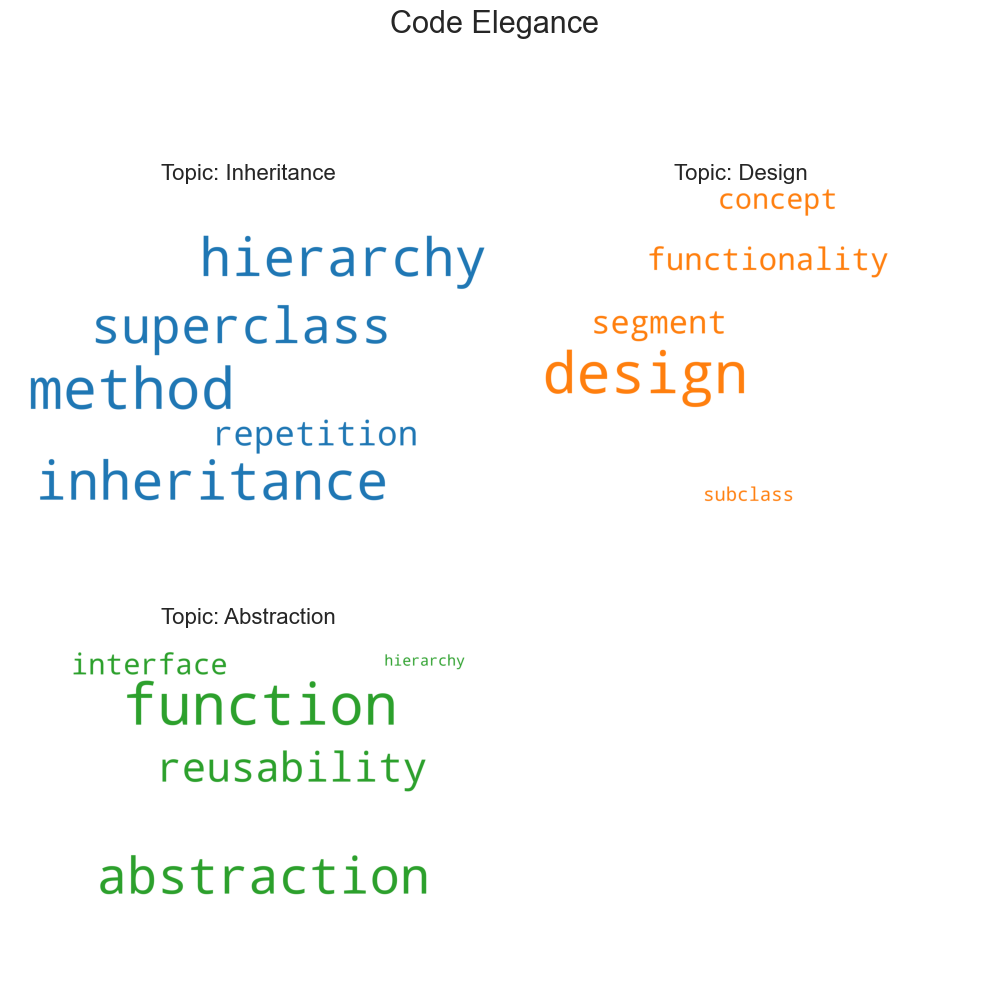

/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_7475/482231609.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_7475/482231609.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_7475/482231609.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


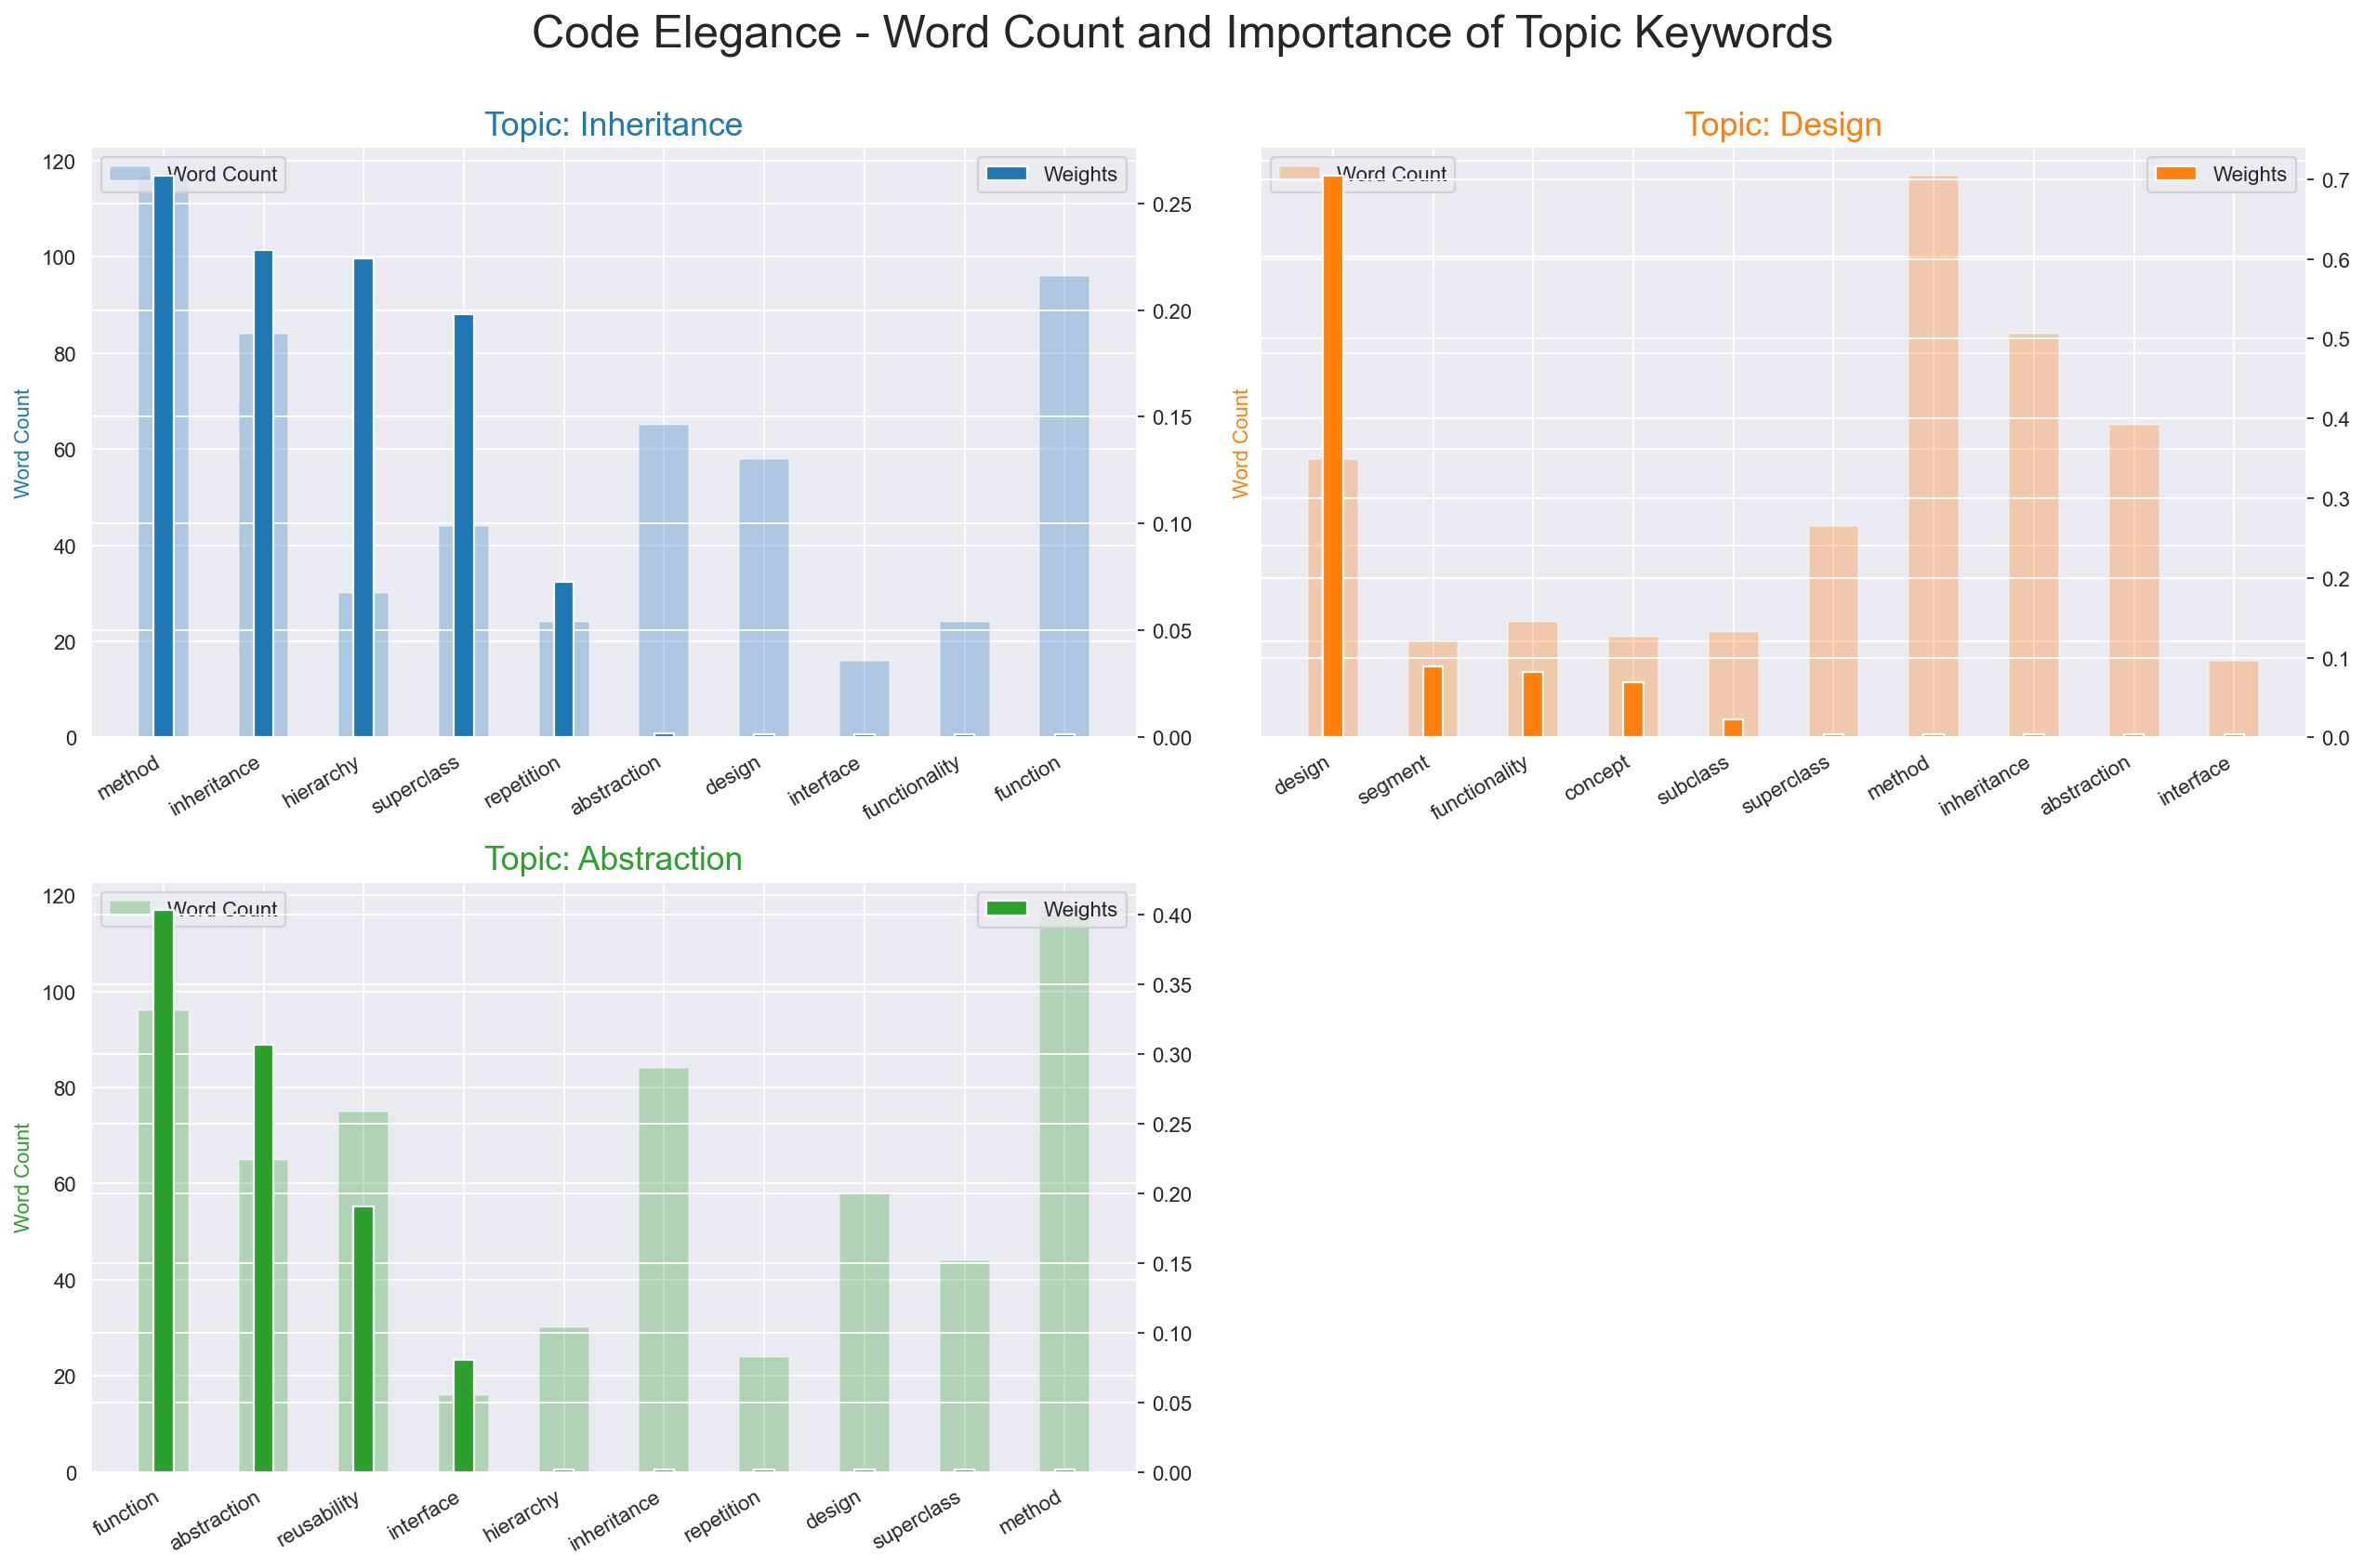

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.301226 -0.208549       1        1  36.405056
2     -0.338333 -0.146712       2        1  36.118654
1      0.037108  0.355261       3        1  27.476290, topic_info=             Term       Freq      Total Category  logprob  loglift
0          design  97.000000  97.000000  Default  14.0000  14.0000
6        function  73.000000  73.000000  Default  13.0000  13.0000
4     abstraction  56.000000  56.000000  Default  12.0000  12.0000
2          method  48.000000  48.000000  Default  11.0000  11.0000
1     inheritance  42.000000  42.000000  Default  10.0000  10.0000
13      hierarchy  41.000000  41.000000  Default   9.0000   9.0000
10     superclass  36.000000  36.000000  Default   8.0000   8.0000
9     reusability  35.000000  35.000000  Default   7.0000   7.0000
11        segment  12.000000  12.000000  Default   6.0000   6.0000
3   functionality  11.000000  11.000000  Default   5.0000   5.0000
5       interface  15.000000  15.000000  Default   4.0000   4.0000
12        concept  10.000000  10.000000  Default   3.0000   3.0000
8      repetition  14.000000  14.000000  Default   2.0000   2.0000
7        subclass   3.000000   3.000000  Default   1.0000   1.0000
2          method  47.888763  48.739402   Topic1  -1.3354   0.9929
13      hierarchy  40.843206  41.665241   Topic1  -1.4946   0.9905
1     inheritance  41.554604  42.417448   Topic1  -1.4773   0.9899
10     superclass  36.048618  36.962146   Topic1  -1.6195   0.9854
8      repetition  13.231162  14.011384   Topic1  -2.6218   0.9532
7        subclass   0.270093   3.751318   Topic1  -6.5133  -1.6206
12        concept   0.263507  10.042319   Topic1  -6.5380  -2.6300
3   functionality   0.273995  11.885578   Topic1  -6.4990  -2.7595
11        segment   0.267747  12.870158   Topic1  -6.5220  -2.8622
5       interface   0.284824  15.257080   Topic1  -6.4602  -2.9705
9     reusability   0.267773  35.153067   Topic1  -6.5219  -3.8669
4     abstraction   0.303737  56.227552   Topic1  -6.3959  -4.2105
6        function   0.272212  73.597142   Topic1  -6.5055  -4.5893
0          design   0.288529  97.512126   Topic1  -6.4473  -4.8125
6        function  72.875263  73.597142   Topic2  -0.9077   1.0085
4     abstraction  55.430471  56.227552   Topic2  -1.1813   1.0041
9     reusability  34.446180  35.153067   Topic2  -1.6570   0.9980
5       interface  14.499797  15.257080   Topic2  -2.5223   0.9675
7        subclass   0.326818   3.751318   Topic2  -6.3148  -1.4221
12        concept   0.326871  10.042319   Topic2  -6.3146  -2.4066
3   functionality   0.327860  11.885578   Topic2  -6.3116  -2.5721
11        segment   0.327873  12.870158   Topic2  -6.3116  -2.6517
8      repetition   0.338936  14.011384   Topic2  -6.2784  -2.7035
10     superclass   0.332516  36.962146   Topic2  -6.2975  -3.6926
13      hierarchy   0.363011  41.665241   Topic2  -6.2098  -3.7246
1     inheritance   0.362704  42.417448   Topic2  -6.2106  -3.7434
2          method   0.330506  48.739402   Topic2  -6.3036  -3.9753
0          design   0.337671  97.512126   Topic2  -6.2821  -4.6473
0          design  96.885926  97.512126   Topic3  -0.3494   1.2854
11        segment  12.274538  12.870158   Topic3  -2.4154   1.2445
3   functionality  11.283723  11.885578   Topic3  -2.4996   1.2399
12        concept   9.451941  10.042319   Topic3  -2.6767   1.2313
7        subclass   3.154408   3.751318   Topic3  -3.7741   1.1185
8      repetition   0.441286  14.011384   Topic3  -5.7410  -2.1661
5       interface   0.472459  15.257080   Topic3  -5.6727  -2.1830
10     superclass   0.581012  36.962146   Topic3  -5.4659  -2.8610
9     reusability   0.439114  35.153067   Topic3  -5.7459  -3.0909
1     inheritance   0.500140  42.417448   Topic3  -5.6158  -3.1486
13      hierarchy   0.459024  41.665241   Topic3  -5.7016  -3.2165
2          method   0.520133  48.739402   Topic3  -5.5766  -3.2483
4 

In [291]:
TOPIC_COUNT = 3
topic_names = {0: 'Inheritance', 1: 'Design', 2: 'Abstraction'}
generate_word_cloud('Code Elegance', models, TOPIC_COUNT, additional_stopwords=additional_stopwords, topic_names=topic_names)
generate_word_count('Code Elegance', models, TOPIC_COUNT, processed_text, topic_names=topic_names)
run_pyLDAvis(models, TOPIC_COUNT)

### Readability

100%|██████████| 9/9 [00:02<00:00,  3.98it/s]

   topic_count  coherence
1            2   -4.55589


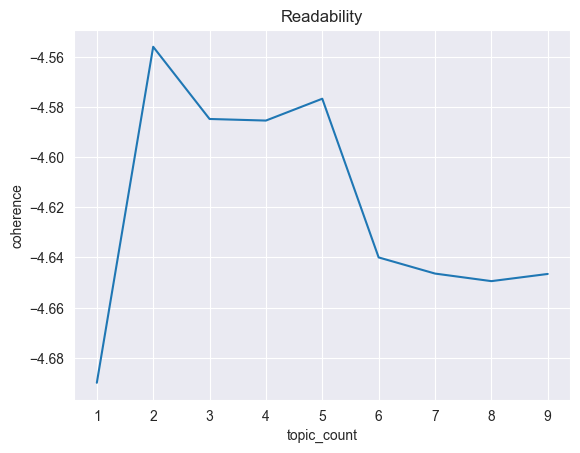

In [353]:
additional_stopwords = ['self', 'use', 'space', 'access', 'codebase', 'identifier', 'issue', 'follow', 'block', 'modifier', 'public', 'read', 'operation', 'function', 'class', 'comment', 'whitespace']
models, corpus, processed_text = run_lda('Readability', additional_stopwords)

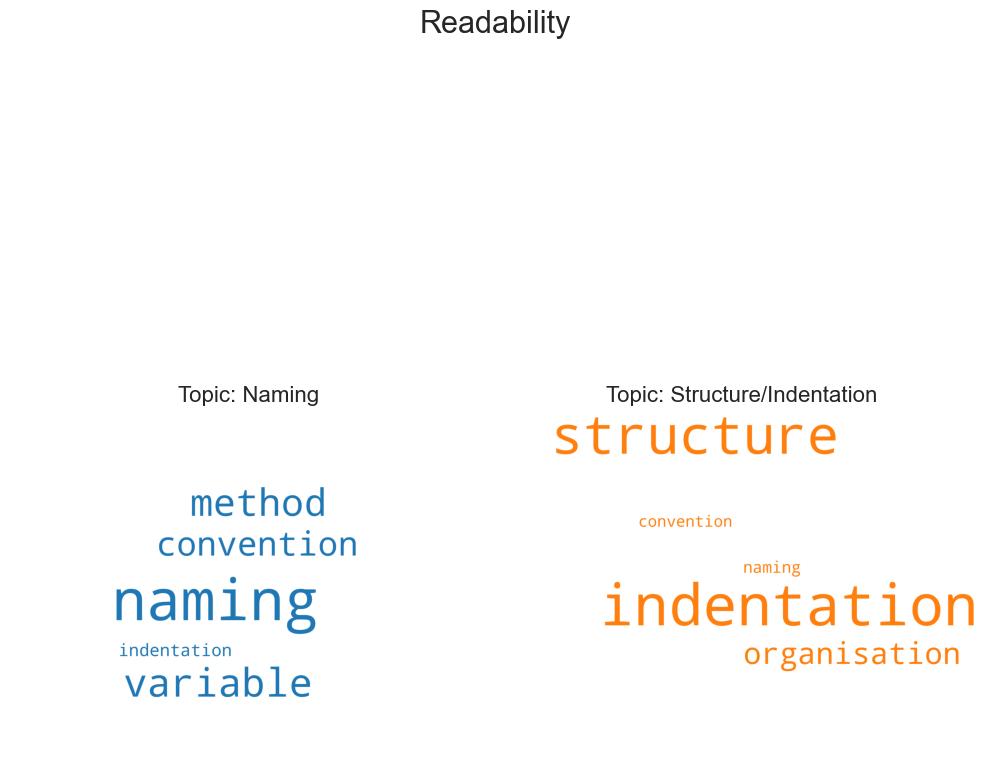

/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_7475/482231609.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_7475/482231609.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


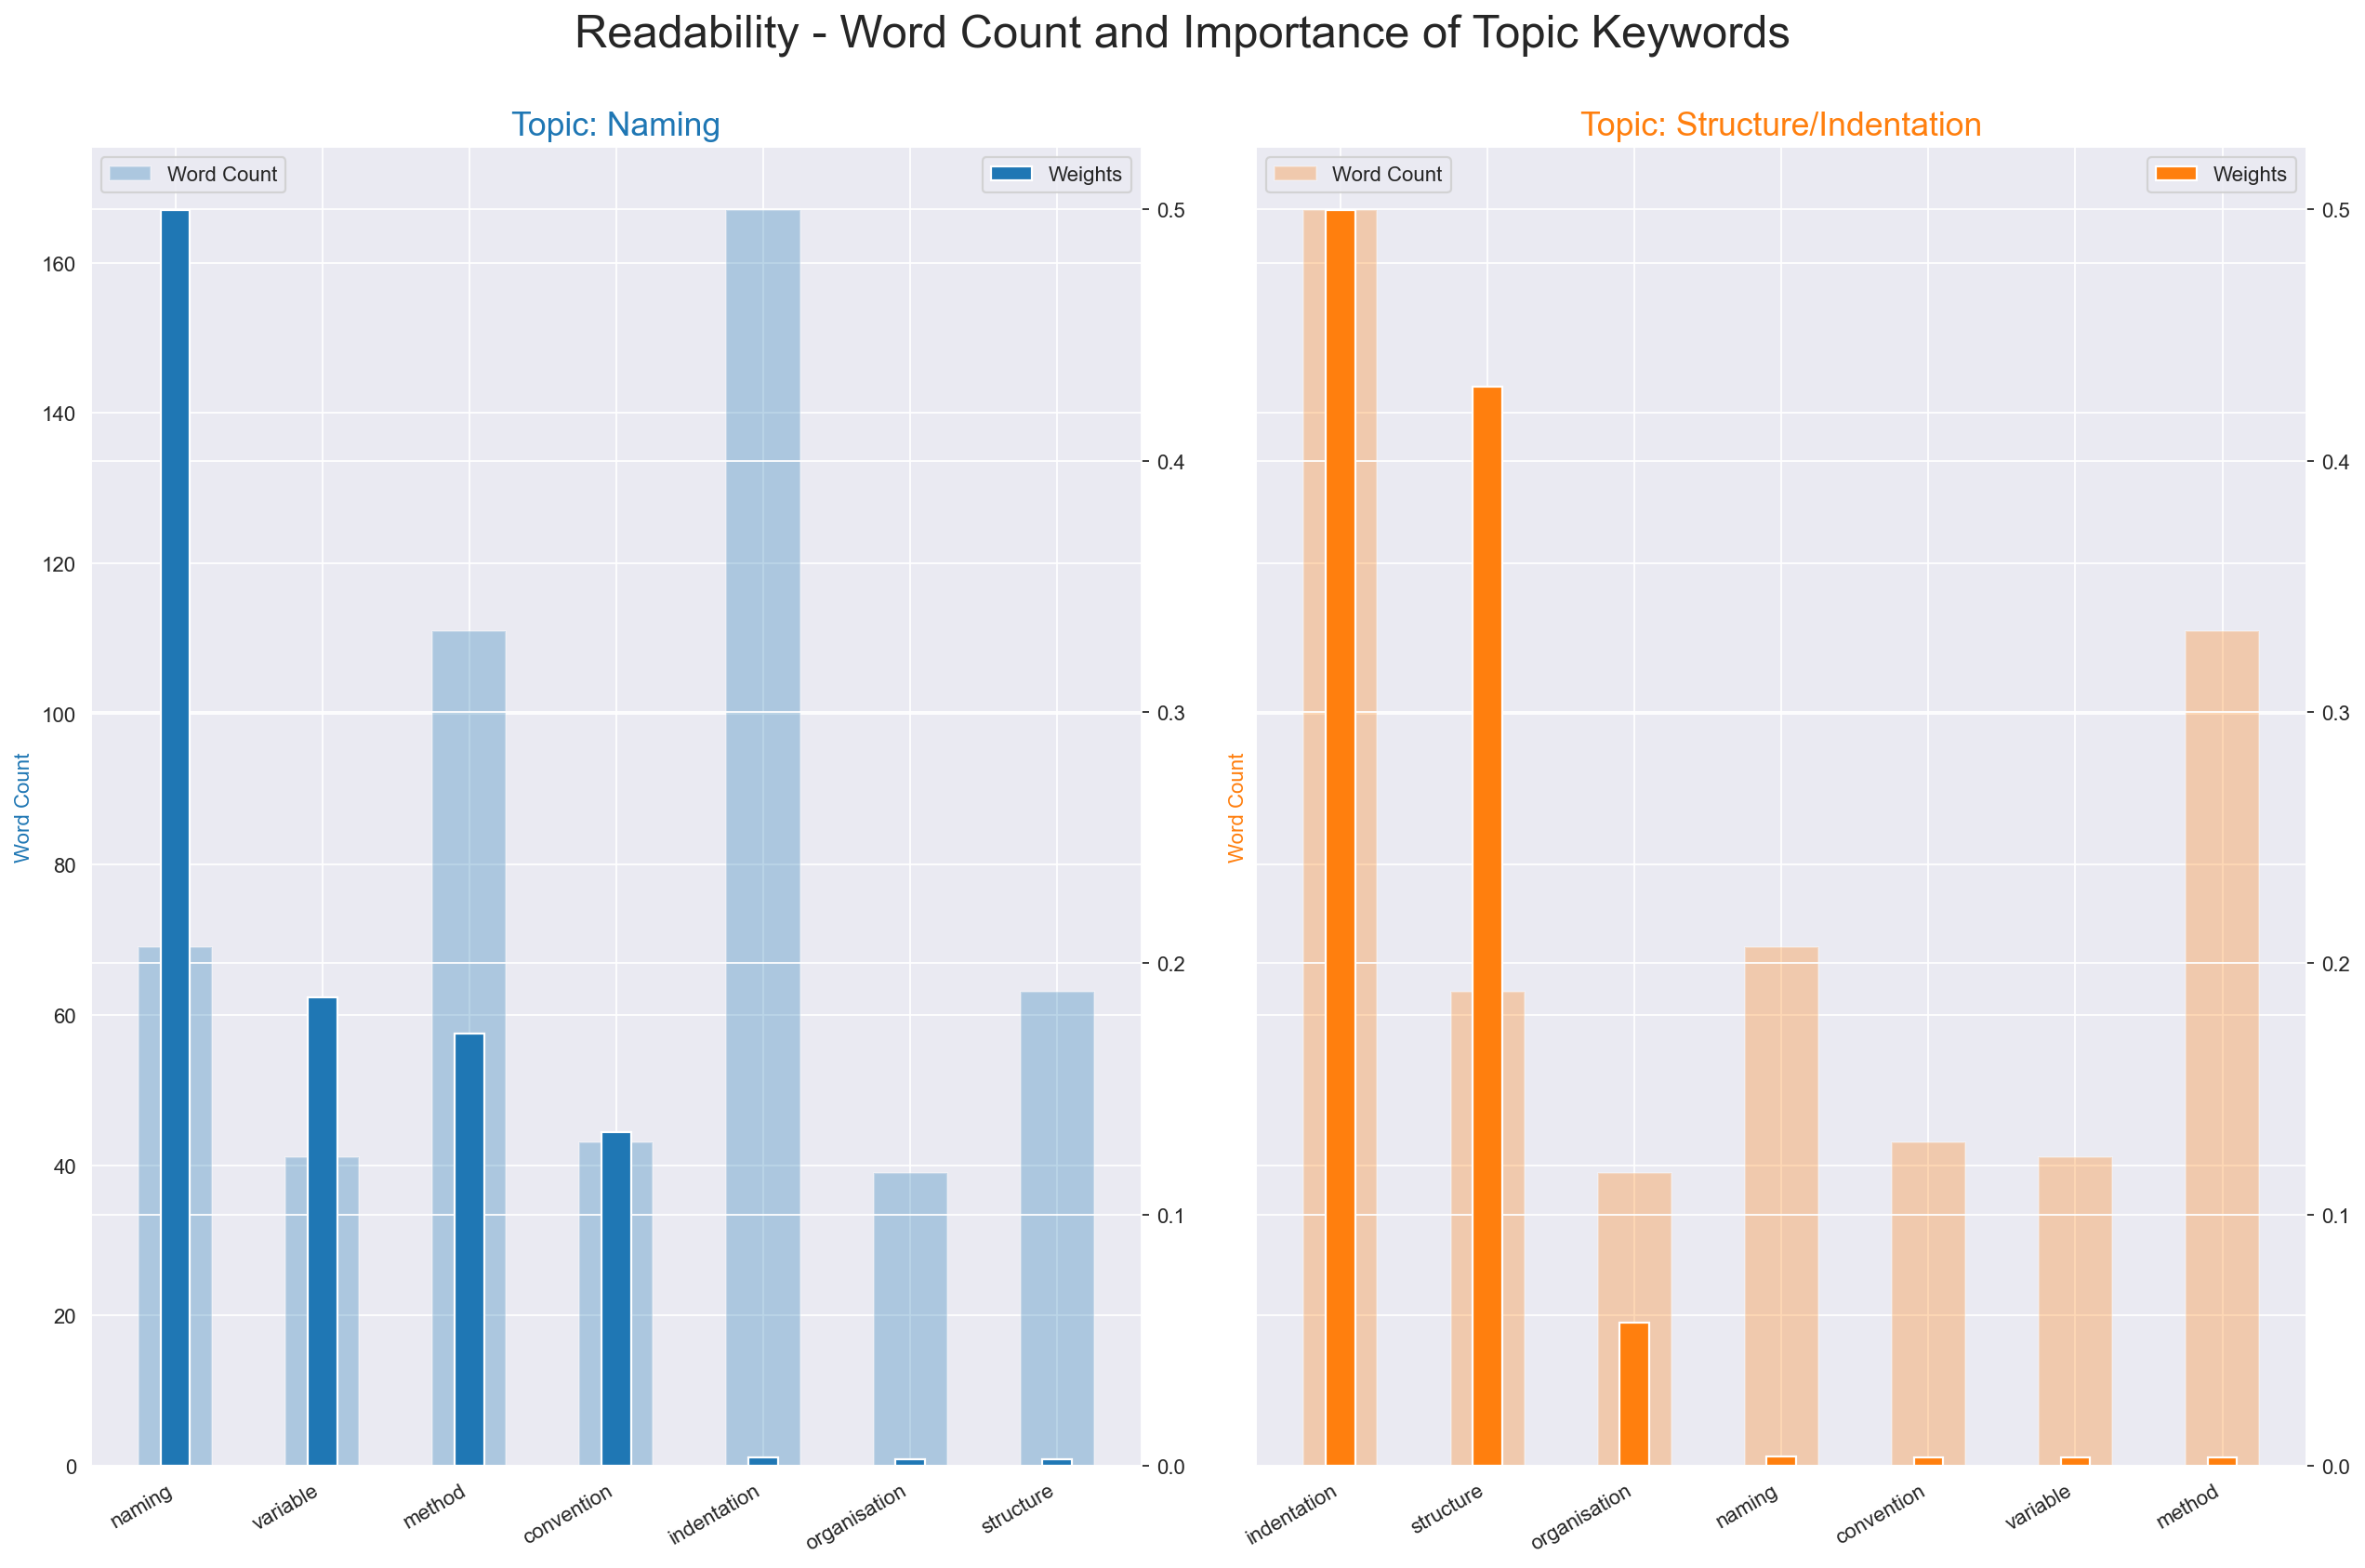

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
1      0.316751  0.0       1        1  51.207112
0     -0.316751  0.0       2        1  48.792888, topic_info=           Term       Freq      Total Category  logprob  loglift
3        naming  90.000000  90.000000  Default   7.0000   7.0000
0   indentation  94.000000  94.000000  Default   6.0000   6.0000
6     structure  81.000000  81.000000  Default   5.0000   5.0000
4      variable  33.000000  33.000000  Default   4.0000   4.0000
1        method  31.000000  31.000000  Default   3.0000   3.0000
2    convention  24.000000  24.000000  Default   2.0000   2.0000
5  organisation  11.000000  11.000000  Default   1.0000   1.0000
6     structure  80.646776  81.130096   Topic1  -0.8452   0.6633
0   indentation  93.843317  94.452711   Topic1  -0.6937   0.6628
5  organisation  10.705426  11.206142   Topic1  -2.8646   0.6236
2    convention   0.653685  24.455339   Topic1  -5.6605  -2.9527
1        method   0.624156  31.385396   Topic1  -5.7067  -3.2484
4      variable   0.630424  33.982422   Topic1  -5.6967  -3.3179
3        naming   0.685971  90.113815   Topic1  -5.6122  -4.2087
3        naming  89.427844  90.113815   Topic2  -0.6936   0.7099
4      variable  33.351998  33.982422   Topic2  -1.6799   0.6989
1        method  30.761240  31.385396   Topic2  -1.7608   0.6975
2    convention  23.801654  24.455339   Topic2  -2.0173   0.6905
5  organisation   0.500716  11.206142   Topic2  -5.8787  -2.3906
0   indentation   0.609395  94.452711   Topic2  -5.6823  -4.3258
6     structure   0.483320  81.130096   Topic2  -5.9141  -4.4055, token_table=      Topic      Freq          Term
term                               
2         1  0.040891    convention
2         2  0.981381    convention
0         1  0.995207   indentation
0         2  0.010587   indentation
1         1  0.031862        method
1         2  0.987721        method
3         1  0.011097        naming
3         2  0.987640        naming
5         1  0.981605  organisation
5         2  0.089237  organisation
6         1  0.998396     structure
4         1  0.029427      variable
4         2  0.971090      variable, R=7, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [355]:
TOPIC_COUNT = 2
topic_names= {0: 'Naming', 1: 'Structure/Indentation'}
generate_word_cloud('Readability', models, TOPIC_COUNT, additional_stopwords=additional_stopwords, topic_names=topic_names)
generate_word_count('Readability', models, TOPIC_COUNT, processed_text, topic_names=topic_names)
run_pyLDAvis(models, TOPIC_COUNT)

### Documentation

100%|██████████| 8/8 [00:02<00:00,  2.84it/s]

   topic_count  coherence
4            6 -12.427582


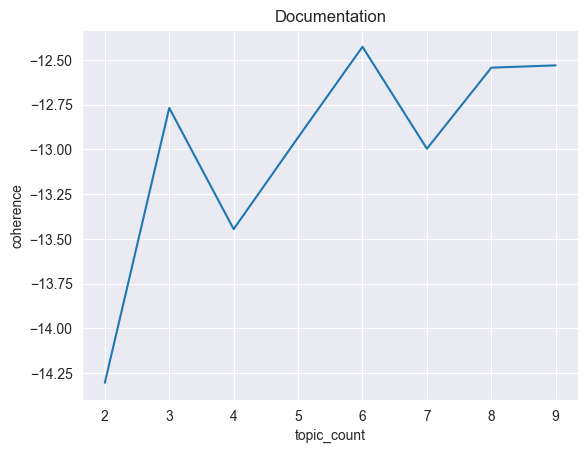

In [626]:
additional_stopwords = ['view', 'simulator', 'color', 'task', 'understanding', 'description', 'system']
models, corpus, processed_text = run_lda('Documentation', additional_stopwords)

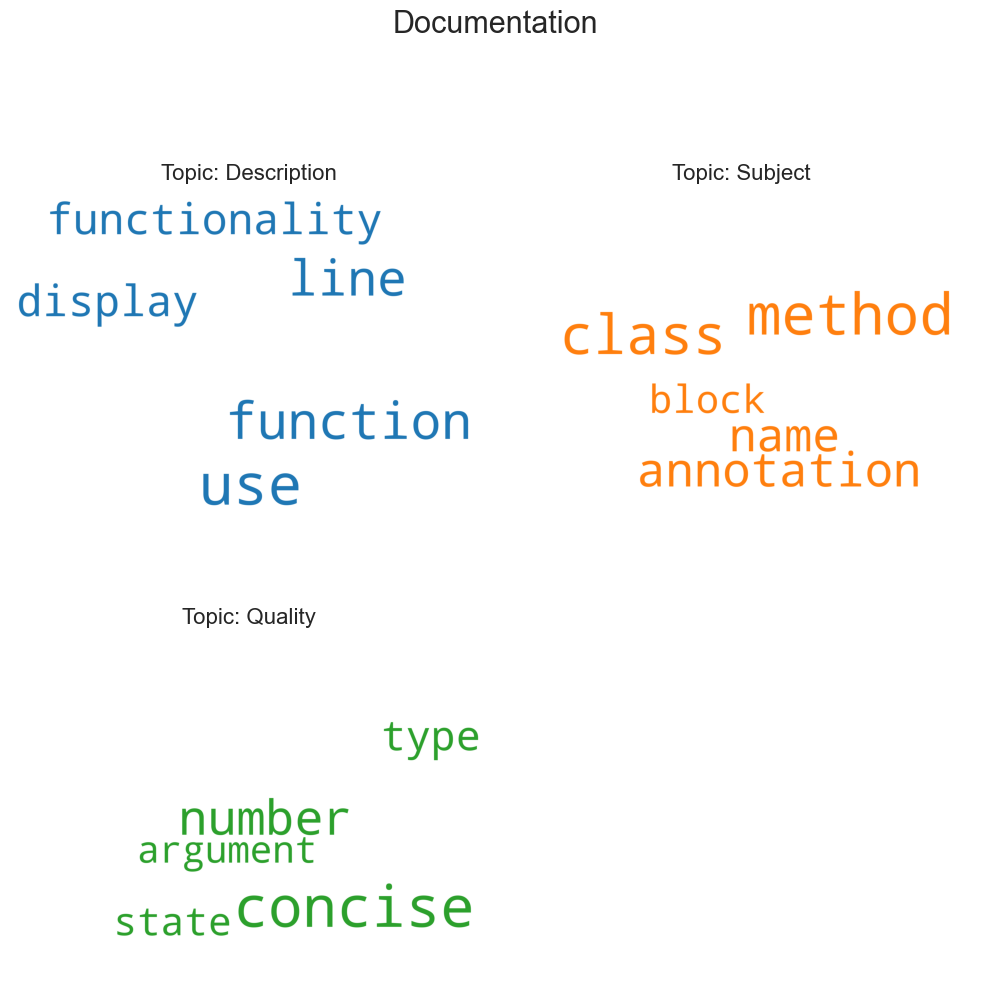

/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_7475/482231609.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_7475/482231609.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
/var/folders/1y/6byzw1px62g2f5w7p_rhb6kh0000gn/T/ipykernel_7475/482231609.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


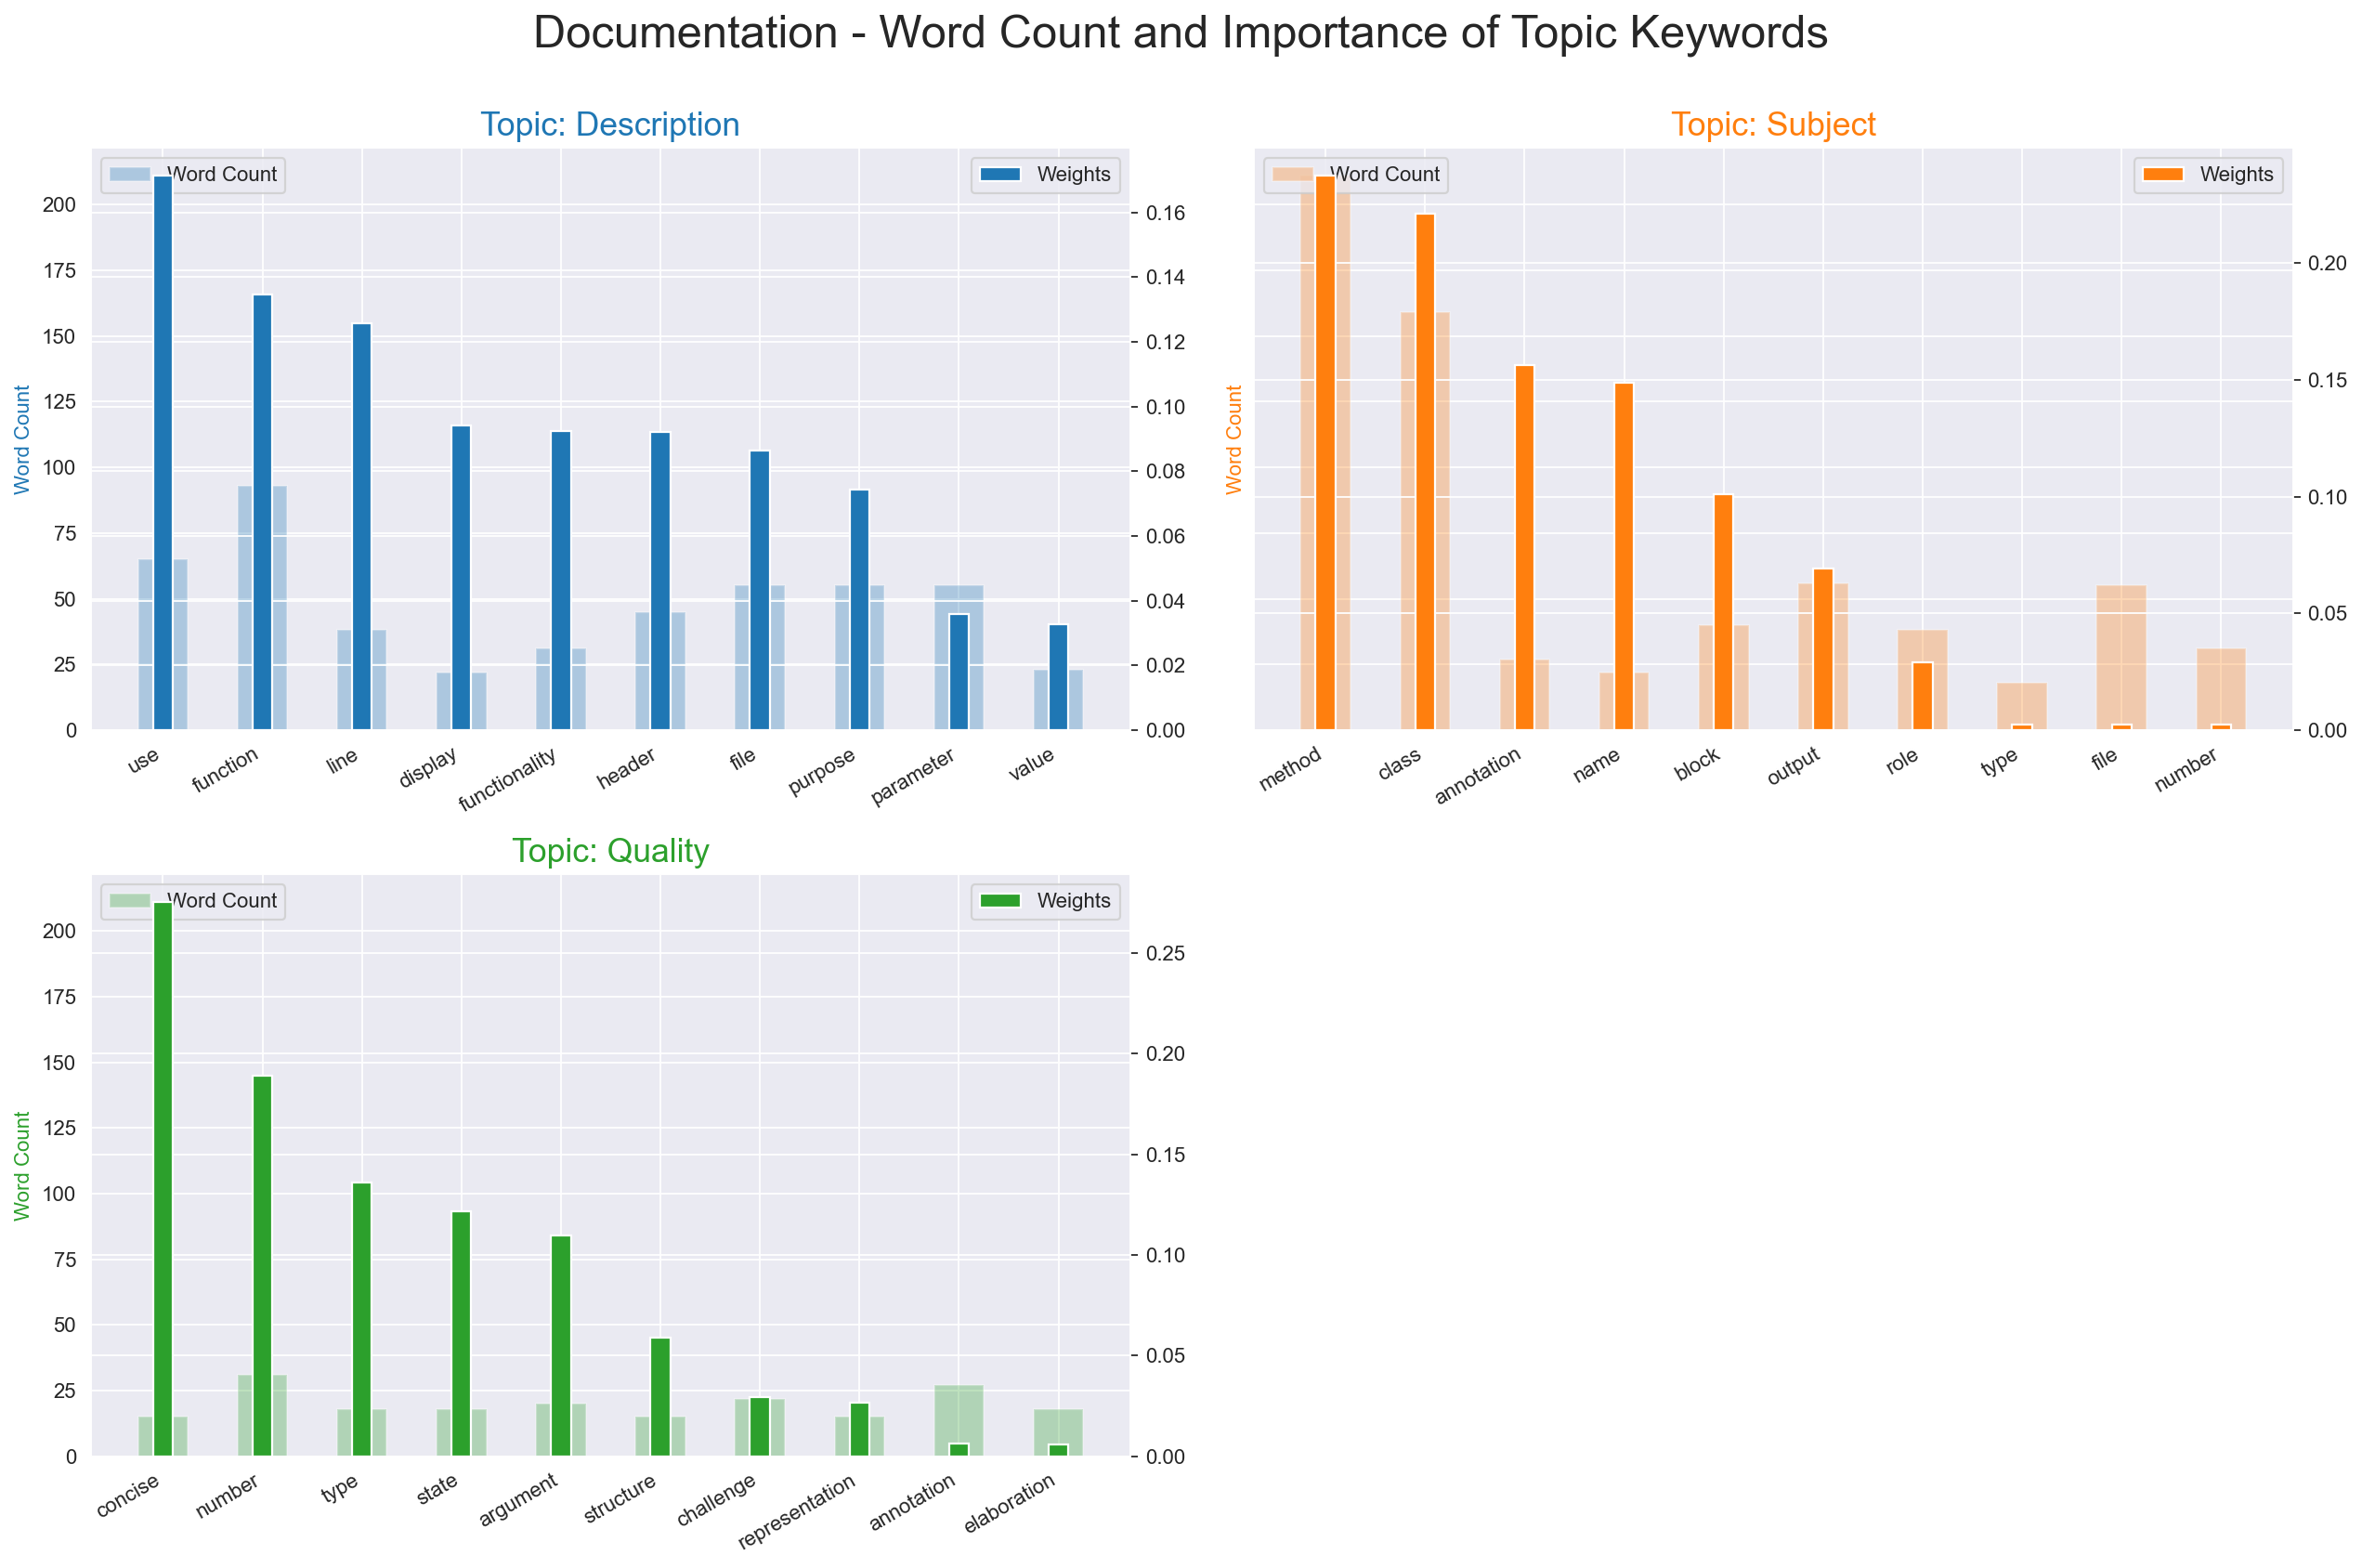

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.252532 -0.228466       1        1  39.610199
1     -0.328514 -0.099718       2        1  36.523908
2      0.075983  0.328184       3        1  23.865894, topic_info=        Term       Freq      Total Category  logprob  loglift
10   concise  44.000000  44.000000  Default  27.0000  27.0000
4     method  58.000000  58.000000  Default  26.0000  26.0000
0      class  54.000000  54.000000  Default  25.0000  25.0000
25    number  31.000000  31.000000  Default  24.0000  24.0000
15       use  46.000000  46.000000  Default  23.0000  23.0000
..       ...        ...        ...      ...      ...      ...
3       line   0.367498  34.083201   Topic3  -6.0744  -3.0971
18  function   0.366149  36.494244   Topic3  -6.0780  -3.1691
15       use   0.355213  46.206426   Topic3  -6.1084  -3.4354
0      class   0.357978  54.724380   Topic3  -6.1006  -3.5969
4     method   0.345952  58.697464   Topic3  -6.1348  -3.7011

[108 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
13        1  0.071341      annotation
13        2  0.903651      annotation
13        3  0.023780      annotation
20        3  0.923704        argument
7         2  0.985917           block
23        3  0.933882       challenge
0         2  0.986763           class
10        3  0.985168         concise
22        1  0.966368         display
24        3  0.617906     elaboration
1         1  0.958822            file
1         2  0.041688            file
18        1  0.986457        function
8         1  0.949742   functionality
2         1  0.950281          header
3         1  0.968219            line
4         2  0.988118          method
21        2  0.964934            name
21        3  0.026804            name
25        2  0.032024          number
25        3  0.960724          number
14        2  0.971868          output
5         1  0.875732       parameter
6         1  0.971087         purpose
26        3  0.792757  representation
16        1  0.872768          return
17        2  0.904837            role
12        3  0.944059           state
11        3  0.890687       structure
19        1  0.042126            type
19        2  0.042126            type
19        3  0.926781            type
15        1  0.973891             use
9         1  0.950644           value, R=27, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

In [628]:
TOPIC_COUNT = 3
topic_names = {0: 'Description', 1: 'Subject', 2: 'Quality'}
generate_word_cloud('Documentation',models, TOPIC_COUNT, additional_stopwords=additional_stopwords, topic_names=topic_names)
generate_word_count('Documentation',models, TOPIC_COUNT, processed_text, topic_names=topic_names)
run_pyLDAvis(models, TOPIC_COUNT)